In [1]:
import os
import yaml
import sys

import re
from collections import Counter
import numpy as np
import math
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def load_yaml_files(dirname, categories=None):
    """
    Load all YAML files in the given directory and merge them into a single dictionary.
    """
    dicts = []
    for filename in os.listdir(dirname):
        with open(os.path.join(dirname, filename), 'r') as f:
            yaml_data = yaml.safe_load(f)
            dicts.append(yaml_data)

    if categories is not None:
        dicts = [d for d in dicts if d['categories'][0] in categories]
    return dicts

def get_convo_pairs(dicts):
    convo_pairs = []
    for d in dicts:
        for convo in d['conversations']:
            for i in range(len(convo) - 1):
                convo_pairs.append([convo[0], convo[i + 1]])

    return convo_pairs


In [57]:
data_dict = load_yaml_files('english') #, ['emotion', 'greeting'])
convo_pairs = get_convo_pairs(data_dict)
print('Number of conversations:', len(convo_pairs))

Number of conversations: 869


## Tokenizer

In [5]:
import re
from collections import Counter
import numpy as np

class CustomTokenizer:
    def __init__(self):
        self.vocab = None
        self.token_to_id = None
        self.id_to_token = None
        self.vocab_size = None
        self.special_tokens = ['<EOS>', '<PAD>']
        self.pad_token_id = -1
        self.eos_token_id = -1

    def fit_on_texts(self, texts, vocab_size=None):
        # Tokenize the texts and build the vocabulary
        tokenized_texts = [self.tokenize(text) for text in texts]
        all_tokens = [token for text_tokens in tokenized_texts for token in text_tokens]
        token_counts = Counter(all_tokens)

        # Create vocabulary with most common tokens
        if vocab_size is not None:
            most_common_tokens = token_counts.most_common(vocab_size)
        else:
            most_common_tokens = token_counts.most_common()

        self.vocab = [token for token, count in most_common_tokens] + self.special_tokens
        self.vocab_size = len(self.vocab)

        # Assign token IDs
        self.token_to_id = {token: i for i, token in enumerate(self.vocab)}
        self.id_to_token = {i: token for i, token in enumerate(self.vocab)}

        self.pad_token_id = self.token_to_id['<PAD>']
        self.eos_token_id = self.token_to_id['<EOS>']

    def tokenize(self, text):
        # Tokenize text into individual tokens
        tokens = re.findall(r'\w+|[^\w\s]', text.lower())
        return tokens

    def encode(self, text, max_length=None):
        # Convert text to a sequence of token IDs
        tokens = self.tokenize(text) + ['<EOS>']
        token_ids = [self.token_to_id.get(token, 0) for token in tokens]  # Assign 0 for out-of-vocabulary tokens

        if max_length is not None:

            n_real_tokens = len(token_ids)

            # Pad or truncate the token IDs to the specified max length
            token_ids = self.pad_or_truncate(token_ids, max_length)

            # Generate attention mask
            attention_mask = [1] * n_real_tokens + [0] * (max_length - n_real_tokens)
            # attention_mask = [1] * len(token_ids) + [0] * (max_length - len(token_ids))
            attention_mask = np.array(attention_mask)

            return token_ids, attention_mask

        return token_ids

    def decode(self, token_ids):
        # Convert token IDs back to text
        tokens = [self.id_to_token.get(token_id, '') for token_id in token_ids]
        text = ' '.join(tokens)
        return text

    def pad_or_truncate(self, token_ids, max_length):
        if len(token_ids) < max_length:
            token_ids = token_ids + [self.pad_token_id] * (max_length - len(token_ids))
        else:
            token_ids = token_ids[:max_length]
        return token_ids


In [6]:
tokenizer = CustomTokenizer()
all_sentences = list(set([pair[0] for pair in convo_pairs] + [pair[1] for pair in convo_pairs]))
tokenizer.fit_on_texts(all_sentences)

In [7]:
tokenizer.vocab[:10]

['.', 'i', 'you', 'a', 'the', ',', 'is', '?', "'", 'of']

In [8]:
tokenizer.encode('Hello, how are you?')

[383, 5, 33, 12, 2, 7, 1964]

In [9]:
# Encode (token IDs) and generate attention mask
tokens, attention_mask = tokenizer.encode('Hello, how are you?', max_length=20)
print(tokens)
print(attention_mask)

[383, 5, 33, 12, 2, 7, 1964, 1965, 1965, 1965, 1965, 1965, 1965, 1965, 1965, 1965, 1965, 1965, 1965, 1965]
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
# Decode (token IDs -> text)
tokenizer.decode([462, 5, 33, 12, 2, 7, 1964, 1965])

'scared , how are you ? <EOS> <PAD>'

## Extra stuff

In [11]:
# maxmimum sequence length
max_seq_len = 0
for pair in convo_pairs:
    tokens = tokenizer.encode(pair[0])
    max_seq_len = max(max_seq_len, len(tokens))
    tokens = tokenizer.encode(pair[1])
    max_seq_len = max(max_seq_len, len(tokens))
max_seq_len += 1
print(f'max_seq_len: {max_seq_len}')

# vocabulary size
vocab_size = tokenizer.vocab_size
print(f'vocab_size: {vocab_size}')

max_seq_len: 53
vocab_size: 1966


## Dataset

In [12]:
class ChatbotDataset(Dataset):
    def __init__(self, convo_pairs, tokenizer, max_length):
        self.tokenizer = tokenizer
        self.convo_pairs = convo_pairs
        self.max_length = max_length

    def __len__(self):
        return len(self.convo_pairs)
    
    def __getitem__(self, index):
        # Get a single example from the dataset
        input, output = self.convo_pairs[index]

        # Convert the input and output sentences to token IDs
        input_ids, input_attention_mask   = self.tokenizer.encode(input, self.max_length)
        output_ids, output_attention_mask = self.tokenizer.encode(output, self.max_length)

        # Convert the token IDs to tensors
        input_ids = torch.LongTensor(input_ids)
        output_ids = torch.LongTensor(output_ids)

        # Convert the attention masks to tensors
        input_attention_mask = torch.LongTensor(input_attention_mask)
        output_attention_mask = torch.LongTensor(output_attention_mask)

        if output_attention_mask.shape != output_ids.shape:
            print(index)

        return input_ids, input_attention_mask, output_ids, output_attention_mask


In [13]:
dataset = ChatbotDataset(convo_pairs, tokenizer, max_length=max_seq_len)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

## Network

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_seq_len, dropout=0.1):
        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2) * -(math.log(10000.0) / embed_size))
        pe = torch.zeros(1, max_seq_len, embed_size)

        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class TransformerChatbot(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_heads, num_layers, max_seq_len):
        super(TransformerChatbot, self).__init__()

        self.max_seq_len = max_seq_len

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, max_seq_len)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_size, num_heads, hidden_size),
            num_layers
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, vocab_size)
        )

    def forward(self, input_ids, input_attention_mask):
        embedded = self.embedding(input_ids)
        embedded = self.positional_encoding(embedded)

        # Transpose the embedded tensor for transformer encoder
        embedded = embedded.transpose(0, 1)
        encoded = self.transformer_encoder(embedded, src_key_padding_mask=~input_attention_mask.bool())

        # Transpose the encoded tensor back to the original shape
        encoded = encoded.transpose(0, 1)

        # Decode the encoded tensor
        output = self.decoder(encoded)
        return output
    
    def generate(self, input_text, tokenizer, device, return_full_text=False, sample=False):
        # Set the model to evaluation mode (dropout + normalization layers won't work)
        self.eval()

        # Encode the input text to token IDs
        input_ids, input_attention_mask = tokenizer.encode(input_text, self.max_seq_len)

        # Convert the token IDs to tensors
        input_ids = torch.LongTensor(input_ids).unsqueeze(0).to(device)
        input_attention_mask = torch.LongTensor(input_attention_mask).unsqueeze(0).to(device)

        # Generate output token IDs
        output_ids = self.forward(input_ids, input_attention_mask)

        if sample:
            # sample from top 5
            output_ids = torch.topk(output_ids, k=5, dim=-1)[1]

            # Get the size of the third dimension
            num_elements = output_ids.size(-1)

            # Choose a random index to sample from
            index = torch.multinomial(torch.ones(num_elements), 1).item()

            # Get the sampled element
            output_ids = output_ids[:, :, index]
        else:
            output_ids = output_ids.argmax(dim=-1)

        # Decode the output token IDs
        output_text_full = tokenizer.decode(output_ids[0].tolist())

        # Remove everything after the first <EOS> token
        output_text = output_text_full.split('<EOS>')[0].strip()

        if return_full_text:
            return output_text, output_text_full
        else:
            return output_text

In [15]:
embedding_size = 128
hidden_size = 128
num_heads = 4
num_layers = 2

## Weighted custom loss

In [16]:
chars = {i:[] for i in range(max_seq_len)}
chars_int = {i:[] for i in range(max_seq_len)}
chars_all = []
for i in range(len(convo_pairs)):
    for convo in convo_pairs[i]:
        tokens = tokenizer.encode(convo, max_length=max_seq_len)[0]

        for j in range(max_seq_len):
            decoded = tokenizer.decode([tokens[j]])

            chars_all.append(decoded)
            chars[j].append(decoded)
            chars_int[j].append(tokens[j])

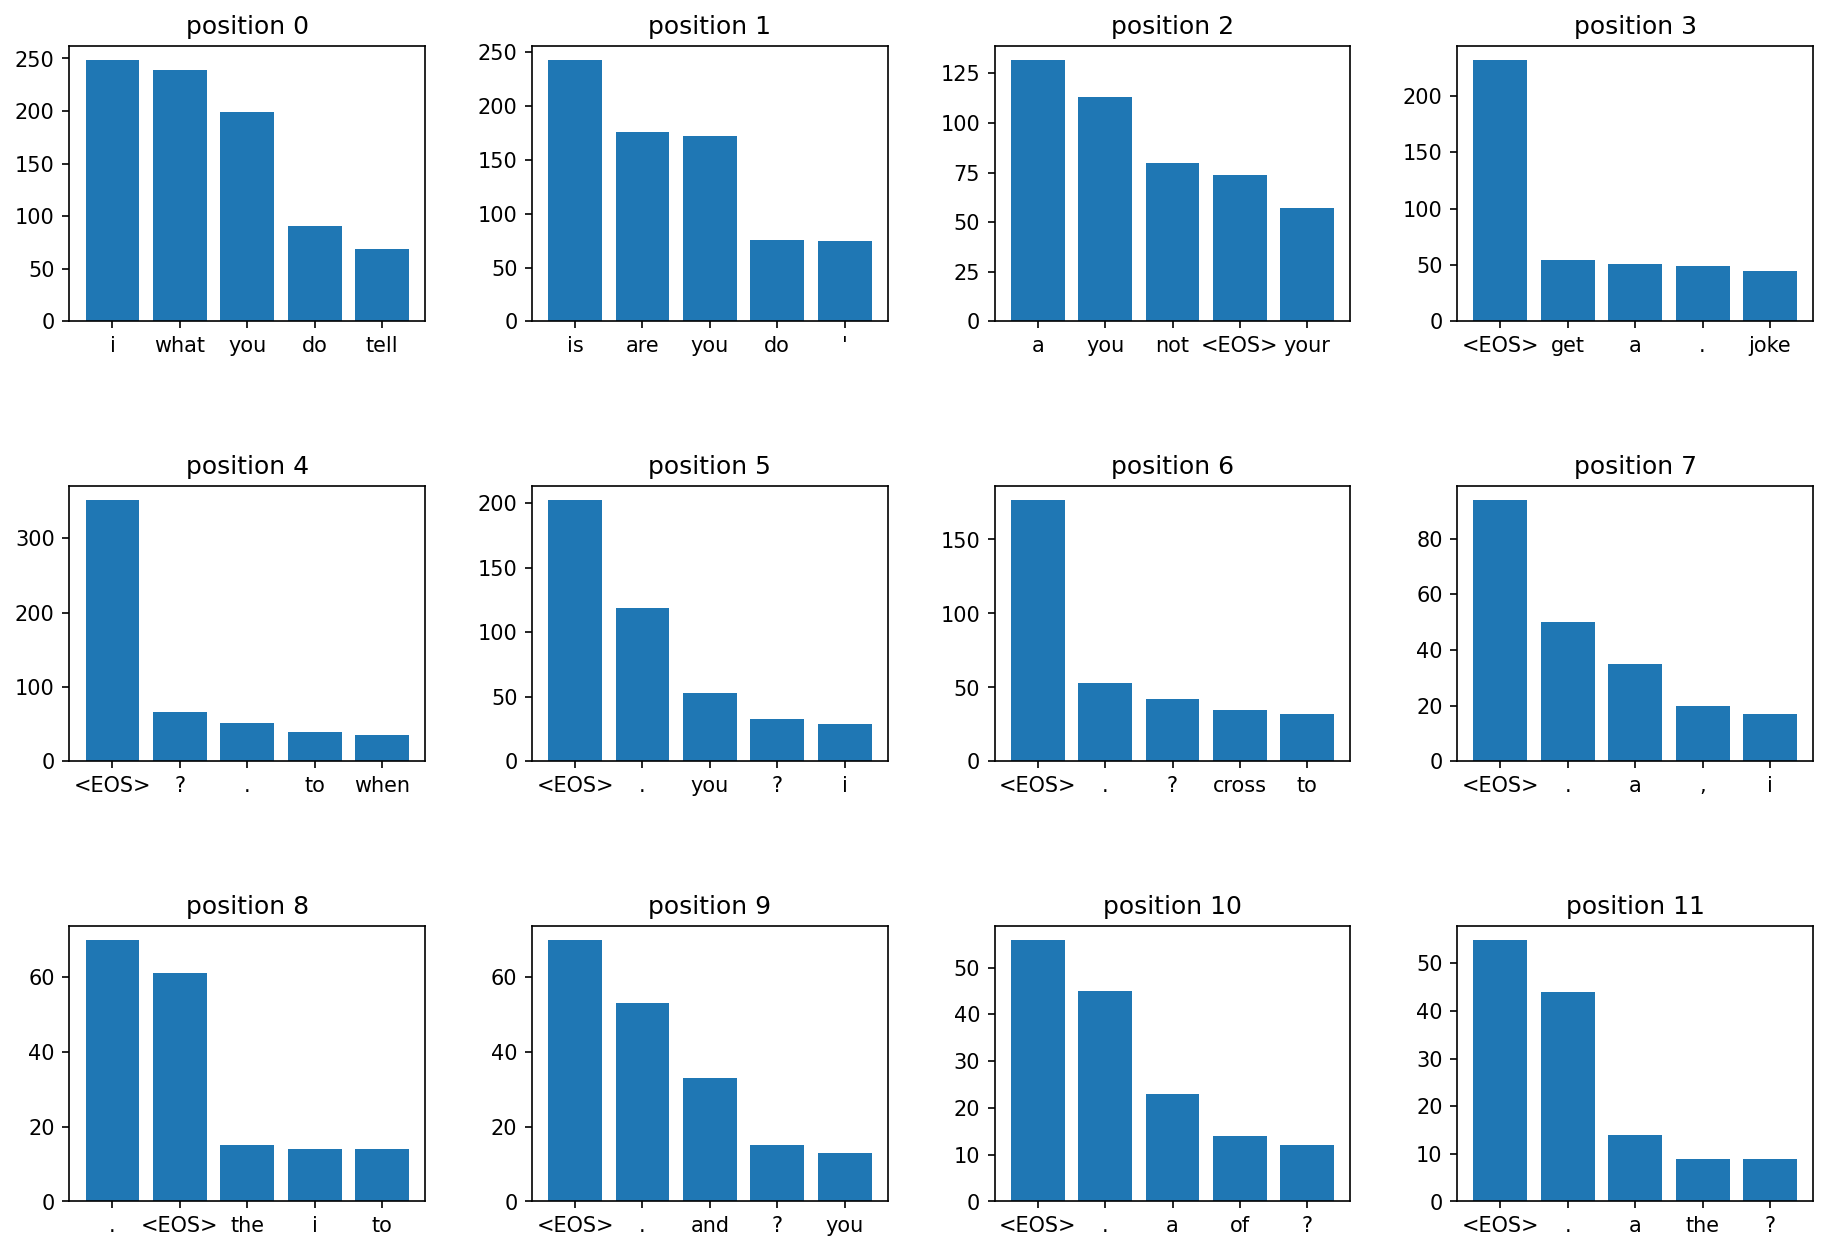

In [17]:
plt.figure(figsize=(15, 10), dpi=150)
gs = gridspec.GridSpec(3, 4, wspace=0.3, hspace=0.6)

# plot top 5 most common characters
for i in range(12):
    counter = Counter(chars[i])
    most_common = counter.most_common(6)

    for j in range(6):
        if most_common[j][0] == '<PAD>':
            most_common.pop(j)
            break
    if len(most_common) == 6:
        most_common.pop()

    ax = plt.subplot(gs[i])
    ax.bar([x[0] for x in most_common], [x[1] for x in most_common])
    ax.set_title(f'position {i}')

In [35]:
class CustomLoss(nn.Module):
    def __init__(self, num_classes, token_weights, tokenizer):
        super(CustomLoss, self).__init__()
        self.num_classes = num_classes
        self.tokenizer = tokenizer

        # self.token_weights = token_weights
        # self.max_seq_len = token_weights.size(0)
        # self.arange_idx = torch.arange(0, max_seq_len).to(device)

    def forward(self, logits, targets):

        # no loss for the padded tokens
        ce_loss = F.cross_entropy(logits.view(-1, self.num_classes), targets.view(-1), reduction='none', ignore_index=self.tokenizer.pad_token_id)

        # bs = logits.size(0)
        # # Create a weight mask that matches the shape of ce_loss
        # weight_mask = self.token_weights[self.arange_idx.repeat(bs), targets.view(-1)]

        # # Apply the weight mask element-wise to the CrossEntropy loss
        # weighted_loss = ce_loss * weight_mask

        # # Average the loss across non-padding positions
        # loss = weighted_loss.mean()

        loss = ce_loss.mean()

        return loss

## Training function

In [36]:
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for batch in data_loader:
        input_ids, input_attention_mask, output_ids, output_attention_mask = batch

        input_ids = input_ids.to(device)
        input_attention_mask = input_attention_mask.to(device)
        output_ids = output_ids.to(device)
        output_attention_mask = output_attention_mask.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, input_attention_mask)

        logits = outputs.log_softmax(dim=-1)
        labels = output_ids

        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # # write and erase loss
        # sys.stdout.write(f'\rLoss: {loss.item():.4f}')

    return total_loss / len(data_loader)

In [48]:
token_weights = None

# Instantiate the TransformerChatbot model
model = TransformerChatbot(vocab_size, embedding_size, hidden_size, num_heads, num_layers, max_seq_len).to(device)

# count the number of trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params}')

# Define the loss function and optimizer
criterion = CustomLoss(vocab_size, token_weights, tokenizer)
optimizer = optim.Adam(model.parameters(), lr=0.0003)

losses = []

Number of parameters: 737454


## Training

In [49]:
str = "Hi, how are you?"
model.generate(str, tokenizer=tokenizer, device=device)

'boll refer boll thousands archive refer serious craft serious serious serious comic comic craft craft feeling feeling feeling feeling feeling craft serious serious serious serious weevils comic experiencing experiencing experiencing experiencing feeling feeling experiencing experiencing experiencing experiencing experiencing experiencing experiencing experiencing relative relative experiencing experiencing serious serious serious serious serious serious comic comic'

In [50]:
# Training loop
num_epochs = 1000   

for epoch in tqdm(range(num_epochs)):
    if epoch == 0:
        str = "Hi, how are you?"
        print("Qn: ", str)
        print('Epoch -1:', model.generate(str, tokenizer, device))  

    train_loss = train(model, data_loader, optimizer, criterion)
    losses.append(train_loss)

    if (epoch + 1) % 10 == 0:
        str = "Hi, how are you?"
        print(f'Epoch {epoch}:', model.generate(str, tokenizer, device))            
        model.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

Qn:  Hi, how are you?
Epoch -1: boll refer boll thousands archive refer serious craft serious serious serious comic comic craft craft feeling feeling feeling feeling feeling craft serious serious serious serious weevils comic experiencing experiencing experiencing experiencing feeling feeling experiencing experiencing experiencing experiencing experiencing experiencing experiencing experiencing relative relative experiencing experiencing serious serious serious serious serious serious comic comic
Epoch 9: i
Epoch 19: i
Epoch 29: i
Epoch 39: i
Epoch 49: i
Epoch 59: i
Epoch 69: i
Epoch 79: i
Epoch 89: i
Epoch 99: good
Epoch 109: good
Epoch 119: good
Epoch 129: good
Epoch 139: good
Epoch 149: good
Epoch 159: okay
Epoch 169: good
Epoch 179: okay
Epoch 189: okay
Epoch 199: good
Epoch 209: good
Epoch 219: fine
Epoch 229: okay
Epoch 239: good
Epoch 249: good
Epoch 259: fine
Epoch 269: fine
Epoch 279: fine
Epoch 289: good
Epoch 299: fine
Epoch 309: like
Epoch 319: good
Epoch 329: fine
Epoch 33

Text(0, 0.5, 'Loss')

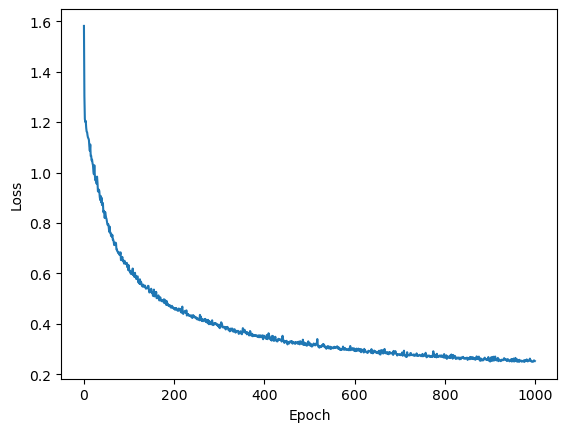

In [52]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [56]:
# # save model
# torch.save(model.state_dict(), 'model.pth')

In [54]:
# model.load_state_dict(torch.load('model.pth'))

## Stochasticity in chatbot response (with sampling)


In [55]:
str = "Hi, how are you?"

print("Qn: ", str, '\n')

print('-'*30)
print('without sampling (argmax)')
print('-'*30)
for i in range(3):
    print(model.generate(str, tokenizer, device, sample=False)) 

print()
print('-'*30)
print('with sampling')
print('-'*30)
for i in range(5):
    print(model.generate(str, tokenizer, device, sample=True))

Qn:  Hi, how are you? 

------------------------------
without sampling (argmax)
------------------------------
fine
fine
fine

------------------------------
with sampling
------------------------------
fine
okay doing i ? and , . ' . fine money today about you entire ? , , i , , ? . m , ? . , get like
too lost great good how ? you . ' s
good m fine well .
too lost great good how ? you . ' s
